In [1]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('Pytorch version:[%s].'%(torch.__version__))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('[%s].'%(device))

Pytorch version:[1.13.0].
[cuda:0].


## Set hyper parameter

In [2]:
EPOCHS = 30
BATCH_SIZE = 128
LEARNING_RATE = 0.001

## Prepare dataset

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), # 정규화 결과가 0 ~ 1
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])

val_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])


DATASET_PATH = './data/'
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(DATASET_PATH + '/val', transform=test_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=22)
val_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=22)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=22)

print('preparing dataset Done')

preparing dataset Done


In [4]:
train_labels_map = {v:k for k, v in train_data.class_to_idx.items()}
test_labels_map = {v:k for k, v in test_data.class_to_idx.items()}

In [5]:
train_data.class_to_idx

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'blenheim_spaniel': 12,
 'bloodhound': 13,
 'bluetick': 14,
 'border_collie': 15,
 'border_terrier': 16,
 'borzoi': 17,
 'boston_bull': 18,
 'bouvier_des_flandres': 19,
 'boxer': 20,
 'brabancon_griffon': 21,
 'briard': 22,
 'brittany_spaniel': 23,
 'bull_mastiff': 24,
 'cairn': 25,
 'cardigan': 26,
 'chesapeake_bay_retriever': 27,
 'chihuahua': 28,
 'chow': 29,
 'clumber': 30,
 'coated_retriever': 31,
 'coated_wheaten_terrier': 32,
 'cocker_spaniel': 33,
 'collie': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'french_bulldog': 44,
 'german_shepherd': 45,
 'giant_schnauzer': 46,
 'golde

In [6]:
data_iter = iter(test_iter)
images, labels = next(data_iter)

In [7]:
images[0].shape

torch.Size([3, 224, 224])

## our model

In [8]:
input = torch.randn(32,2,3,5)
print(input[0])
m = nn.Flatten()
a = m(input[0]).size()
a

tensor([[[ 0.0172,  0.6140,  1.2132, -1.5169,  0.5771],
         [-0.8311, -1.1686, -0.9130, -0.8191,  0.7488],
         [-0.1510,  0.7882, -0.8376,  0.3931, -0.1043]],

        [[ 1.3107, -0.6331, -0.1924,  2.1926,  1.0554],
         [ 0.8825,  0.7169, -0.7684, -0.4822,  0.2922],
         [ 1.3777, -0.1817,  0.1137, -0.4507,  2.3437]]])


torch.Size([2, 15])

In [9]:
class LeNet(nn.Module):
    def __init__(self, n_classes):
        super(LeNet, self).__init__()
        self.n_classes = n_classes

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding= 0),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Sigmoid(),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )
        
        self.classifer = nn.Sequential(
            nn.Linear(in_features=288120, out_features=84),
            nn.Tanh(),
            nn.Linear(84, self.n_classes),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifer(x)
        return x

    # def test(self):
    #     net = LeNet(self.n_classes)
    #     x = torch.randn(1, 3, 224, 224)
    #     y = net(x)
    #     print(y.size())

        
        

### train

In [10]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) 
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

### evaluate

In [11]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [12]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model
 



In [13]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f'Number of Total Parameters: {total_params: ,d}')

NameError: name 'model' is not defined

In [14]:
model = LeNet(len(train_labels_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

base = train_baseline(model, train_iter, val_iter, optimizer, EPOCHS)  	 #(16)
torch.save(base,'baseline.pt')

-------------- epoch 1 ----------------
train Loss: 4.7819, Accuracy: 1.47%
val Loss: 4.7817, Accuracy: 1.48%
Completed in 0m 33s
-------------- epoch 2 ----------------
train Loss: 4.7824, Accuracy: 1.47%
val Loss: 4.7823, Accuracy: 1.48%
Completed in 0m 18s
-------------- epoch 3 ----------------
train Loss: 4.7743, Accuracy: 1.47%
val Loss: 4.7742, Accuracy: 1.48%
Completed in 0m 19s
-------------- epoch 4 ----------------
train Loss: 4.7733, Accuracy: 1.47%
val Loss: 4.7733, Accuracy: 1.48%
Completed in 0m 19s
-------------- epoch 5 ----------------
train Loss: 4.7727, Accuracy: 1.47%
val Loss: 4.7728, Accuracy: 1.48%
Completed in 0m 19s
-------------- epoch 6 ----------------
train Loss: 4.7727, Accuracy: 1.47%
val Loss: 4.7727, Accuracy: 1.48%
Completed in 0m 19s
-------------- epoch 7 ----------------
train Loss: 4.7721, Accuracy: 1.47%
val Loss: 4.7721, Accuracy: 1.48%
Completed in 0m 19s
-------------- epoch 8 ----------------
train Loss: 4.7724, Accuracy: 1.47%
val Loss: 4.77

Exception ignored in: <function _releaseLock at 0x7fc6b6676ee0>
Traceback (most recent call last):
  File "/home/seongwoo/anaconda3/envs/torch/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


-------------- epoch 20 ----------------
train Loss: 4.7732, Accuracy: 1.47%
val Loss: 4.7732, Accuracy: 1.48%
Completed in 0m 19s


KeyboardInterrupt: 

In [ ]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 3, 224, 224).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

In [ ]:
# traning phase
print_every = 1
best_accuracy = 0
print('Start training !')
checkpoint_dir = 'weight'

if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) != 0:
    model = torch.load(f'{checkpoint_dir}/model.pt')
    model.load_state_dict(
        torch.load(f'{checkpoint_dir}/model_state_dict.pt')
    )
    checkpoint = torch.load(f'{checkpoint_dir}/all.tar')
    # model.load_state_dict(checkpoint['model])
    optimizer.load_state_dict(checkpoint['optimizer'])

else:
    model = Model(hidden_size=[64, 32, 64]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)


# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:
        X = batch_img.view(-1, 3, 224, 224).to(device)
        Y = batch_lab.to(device)

        # Inference & Calculate loss
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_val_sum += loss

        if ((epoch%print_every) == 0) or (epoch == (EPOCHS -1 )):
            # accr_val = M.test(x_test, y_test, batch_size)
            loss_val_avg = loss_val_sum / len(train_iter)
            accr_val = test_eval(model, test_iter, BATCH_SIZE)
             
            print(f'epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracyL:[{accr_val:.3f}]')

        if accr_val > best_accuracy:
            best_accuracy = accr_val
            if not os.path.exists(checkpoint_dir):
                os.mkdir(checkpoint_dir)
            print(f'Model Saved : acc - {accr_val}')

            torch.save(model, f'{checkpoint_dir}/model.pt')
            torch.save(model.state_dict(), 
                   f'{checkpoint_dir}/model_state_dict.pt')  
            torch.save({
                'model' : model.state_dict(),
                'optimizer' : optimizer.state_dict()   
                      }, f'{checkpoint_dir}/all.tar')
    if abs(accr_val - best_accuracy) < 0.05:
        print('accr_val is same --- stop iterate')
        break
print('Training Done !')
        

Start training !
epoch:[1/10] cost:[0.039] test_accuracyL:[2.352]
Model Saved : acc - 2.3517978620019435
epoch:[1/10] cost:[0.079] test_accuracyL:[2.313]
epoch:[1/10] cost:[0.118] test_accuracyL:[2.274]
epoch:[1/10] cost:[0.158] test_accuracyL:[2.255]
epoch:[1/10] cost:[0.197] test_accuracyL:[2.216]
epoch:[1/10] cost:[0.236] test_accuracyL:[2.196]
epoch:[1/10] cost:[0.275] test_accuracyL:[2.255]
epoch:[1/10] cost:[0.314] test_accuracyL:[2.274]
epoch:[1/10] cost:[0.353] test_accuracyL:[2.255]
epoch:[1/10] cost:[0.393] test_accuracyL:[2.293]
epoch:[1/10] cost:[0.432] test_accuracyL:[2.274]
epoch:[1/10] cost:[0.471] test_accuracyL:[2.235]
epoch:[1/10] cost:[0.510] test_accuracyL:[2.235]
epoch:[1/10] cost:[0.549] test_accuracyL:[2.293]
epoch:[1/10] cost:[0.588] test_accuracyL:[2.313]
epoch:[1/10] cost:[0.627] test_accuracyL:[2.255]
epoch:[1/10] cost:[0.667] test_accuracyL:[2.235]
epoch:[1/10] cost:[0.706] test_accuracyL:[2.216]
epoch:[1/10] cost:[0.745] test_accuracyL:[2.235]
epoch:[1/10] 

In [ ]:
# test_iter = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=True, num_workers=1)
data_iter = iter(test_iter)
images, labels = next(data_iter)

In [ ]:
def imshow(image, ax = None, title = None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.thick_params(axis = 'both', length = 0)
    ax.set_title(title)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

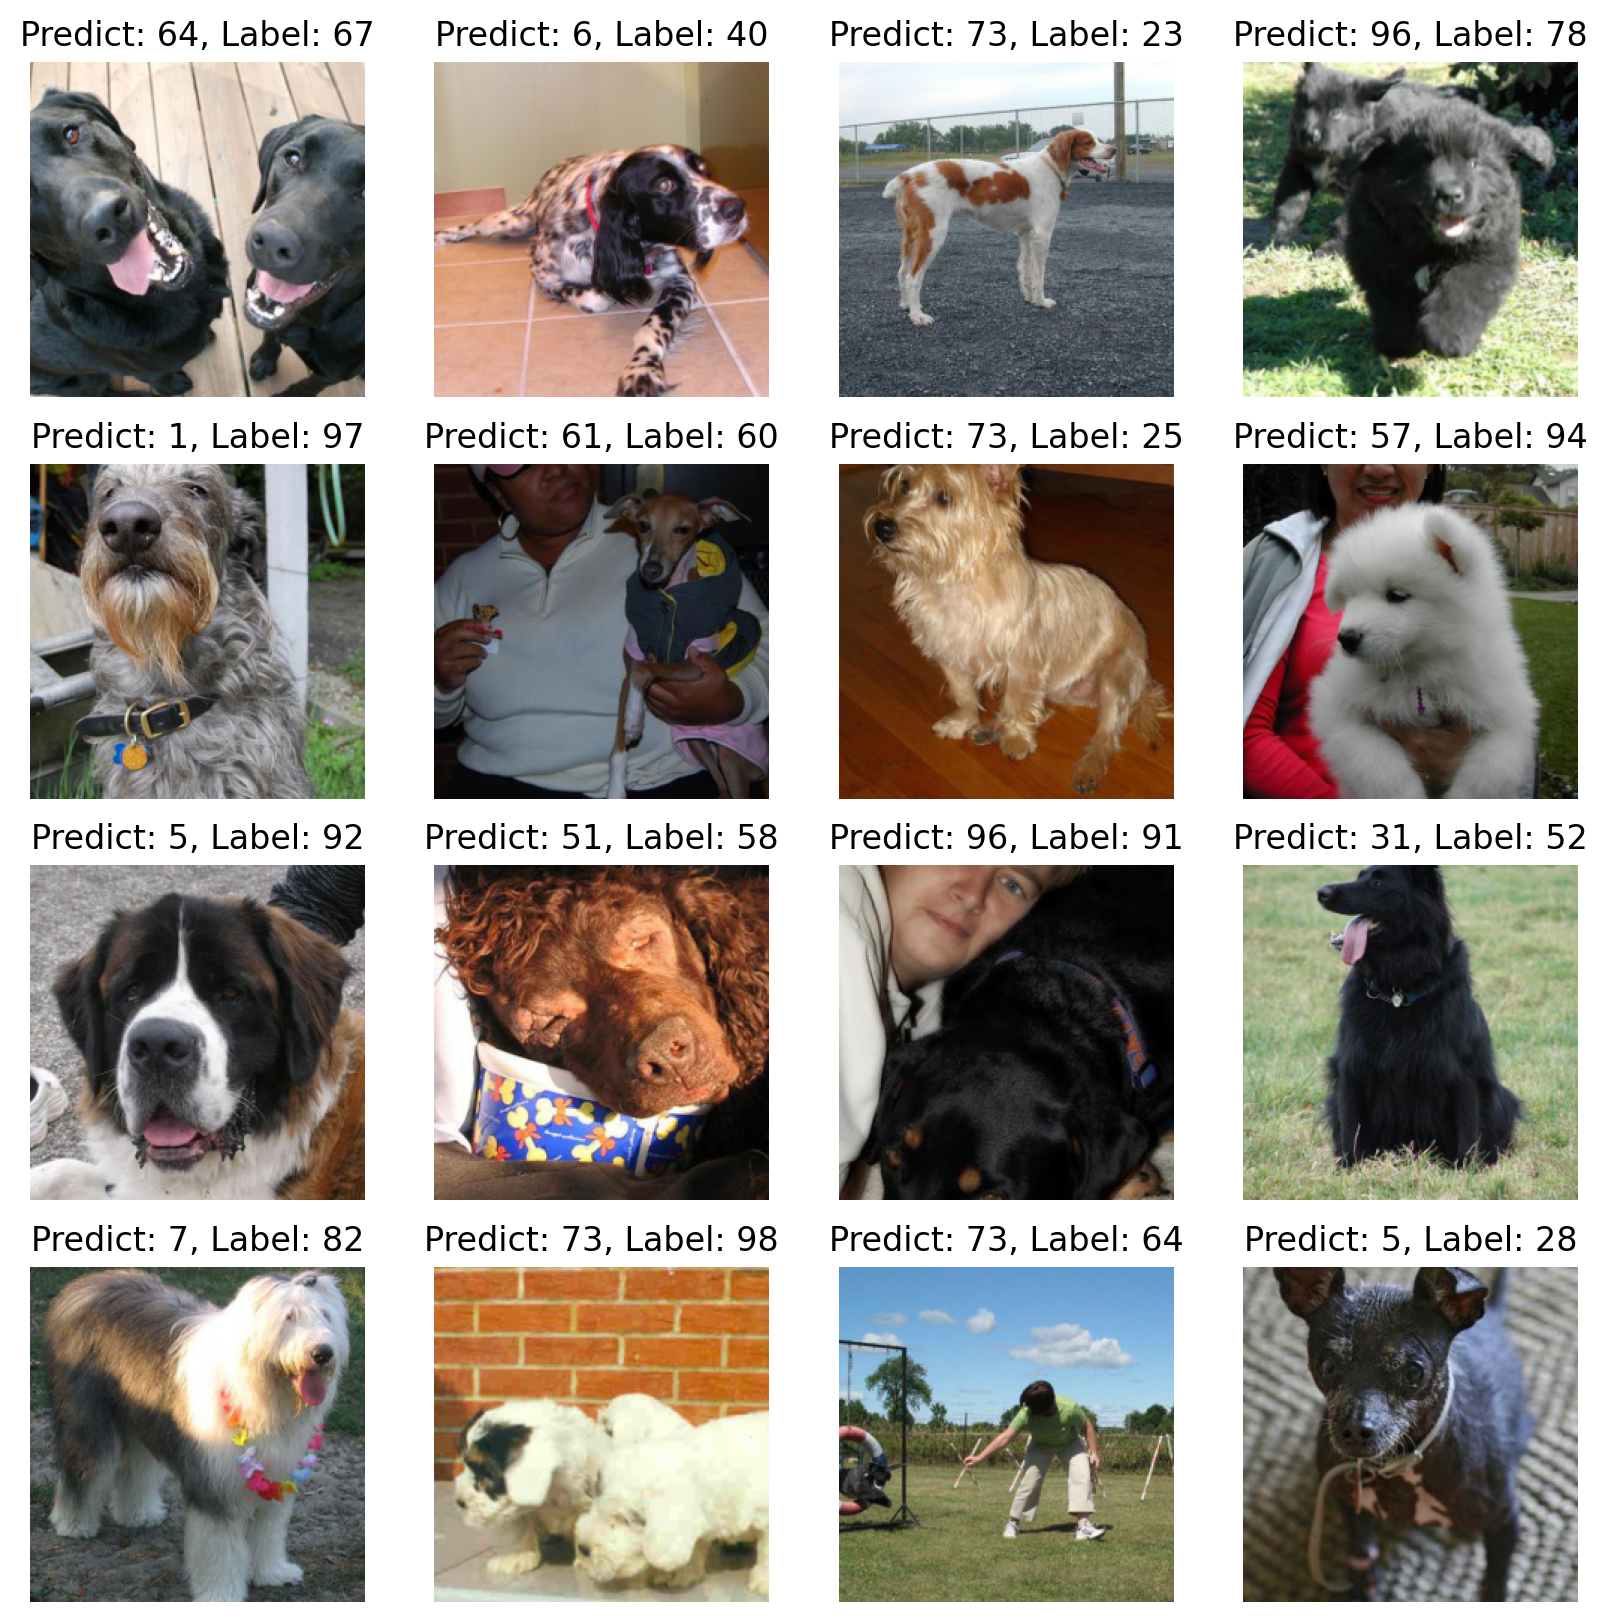

In [ ]:
n_sample = 16
# sample_indices = np.random.choice(len())
test_x = images[:n_sample]
test_y = labels[:n_sample]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))
    model.train()

y_pred = y_pred.argmax(axis = 1)

plt.figure(figsize=(10, 10))

for idx in range(n_sample):
    ax = plt.subplot(4,4, idx+1)
    predict_label = test_labels_map[y_pred[idx]]
    origin_label = test_labels_map[test_y[idx]]

    title = f'Predict: {predict_label}, Label: {origin_label}'
    imshow(test_x[idx], ax, title)
    plt.subplot(4, 4, idx+1)
    # plt.imshow(test_x[idx].numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")
plt.show()

In [ ]:
from sklearn import metrics as mt

In [ ]:
y_pred

tensor([ 73,   1, 100, 104,   7,   1,  79,  31,  31,  73, 100,   7,  51,   7,
         73,  31], device='cuda:0')

In [ ]:
acc = mt.accuracy_score(test_y.tolist(), y_pred.tolist())

In [ ]:
acc

0.0